#  **An Introduction to `fenonics`**
### *Generating Dispersion Diagrams with `FenicsX`*

**Josh Tempelman**

University of Illinois at Urbana Champaign

jrt7@illinois.edu


## Conents:

This script shows how to use the functions from the `fenonics` modules to 

1. Creating the unit cell mesh

2. Visualizing the mesh

3. Generating a dispersion diagram on a default IBZ

4. Generating a disperison diagram on a custom IBZ

5. Post-procssing the disperision computations

6. Visualizng the Bloch-eigenvectors on the mesh

The `fenonics` software is built on the following dependecies:

- `gmsh`
- `Petsc`
- `Scipy`
- `dolfinx`
- `dolfinx-mpc`

## Brief summary of workflow

1. The `gmsh-api` module generates a mesh parameterized by an internal void geometry
2. `dolfinx` builds a function space on the mesh based on a Bloch-ansatz weak form
4. `dolfinx-mpc`applies the necessary periodc BCs and returns the mass and stiffness matrices
5. `scipy` solves the complex eigenproblem at a given wavenumber
6. `fenonics` packages all the operations to conviently solve over an IBZ, post-process solutions, and visualization results

![image.png](attachment:image.png)

For details on these functions and their implementation, see the `Tutorial_Detailed` noteook, or see the support files within the `fenonics` module

In [16]:
# Genearal imports                                   
import numpy as np
import matplotlib.pyplot as plt
import pyvista
import dolfinx
from dolfinx.io.gmshio  import model_to_mesh
import gmsh
from mpi4py import MPI


# Fenonic Import                                   
import fenonics

## Part 1: Generating a mesh

We start by defining some parameters for the void in our square unit cell


    a_len   -            Charecterstic unit cell length (primitive basis)

    r        -           vector of points to fit spline to

    Nquads    -          Number of quadrants to repeat spline through (radially)
    
    offset     -         Offset angle for inclusion geometry

    iscut       -        Choose if inclusion is void or an filled
    
    da      -           Nominal distance between nodes

    refinement_level -   Choose how much denser mesh gets around refinement field

    refinement_dist  -   Maximum distance of refinement field from refined edges
    
    isrefined        -   Choose whether or not to refine mesh around internal edges

    meshalg          -   Meshing algorithm for gmsh to use

We convert the gmsh object to a dolfinx mesh. The `model_to_mesh` module returns the mesh in the correct format along with `ct` which account for domain tags constructed in `gmsh`. Thses tags will be needed if assigneing material propeties to multiple domains
 
The quanties are $c$ and $\rho$, for the equation

$$
c^2\nabla u(x,t) - \frac{\partial^2}{\partial t^2}u(x,t) = 0
$$

If the inclusion gemoetry is not a cut out (`cut = False`), then ehere are two domains in the unit cell that need to be defined, so that `c` and `rho` are lists of length 2. Otherwise, they are length 1 for the single domain, 

In [17]:
# Inputs to meshing program
cut         = True
a_len       =   .1
offset      =   0*np.pi
Nquads      =   4
da                  =   a_len/12
meshalg             =   6
refinement_level    =   6
refinement_dist     =   a_len/5
meshalg                 = 6
r  =   np.array([1,.2,.9,.2])*a_len*.95
gmsh.model, xpt, ypt = fenonics.get_mesh_SquareSpline(a = a_len,  
                                                r = r,  Nquads = Nquads,
                                                refinement_level= refinement_level,
                                                da = da,
                                                refinement_dist = refinement_dist,
                                                symmetry= 'rotated')

# Define material properties on the mesh
if not cut:
    c           = [1500,5100]   # if solid inclusion (mutlple materail model)
    rho         = [1e3,7e3]     # if solid inclusion (mutlple materail model) 
else:
    c           = [30]          # if void inclusion  (if iscut)
    rho         = [1.2]         # if void inclusion  (if iscut)

# Import to dolfinx               
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh, ct, _ = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)



Info    : Clearing all models and views...
Info    : Done clearing all models and views
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
 --------- ERROR HERE --------------
Info    : Error in transformation from curve 2 (23-21) to 4 (24-23) (minimal transformed node distances 0 0.141421, tolerance 1.41563e-09)
Info    : Error in transformation from curve 3 (22-24) to 1 (21-22) (minimal transformed node distances 0.223607 0.1, tolerance 1.41563e-09)
 --------- ERROR HERE --------------
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (BSpline)
Info    : Done meshing 1D (Wall 0.108803s, CPU 0.108924s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0348577s, CPU 0.036658s)
Info    : 1435 nodes 2859 elements
to here


# Part 2: Plot the design vector and the produced mesh

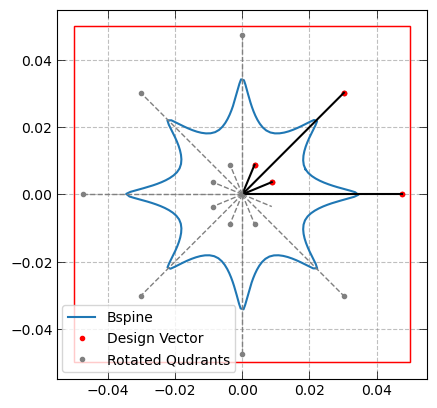


No module named 'trame'

Falling back to a static output.
  warnings.warn(



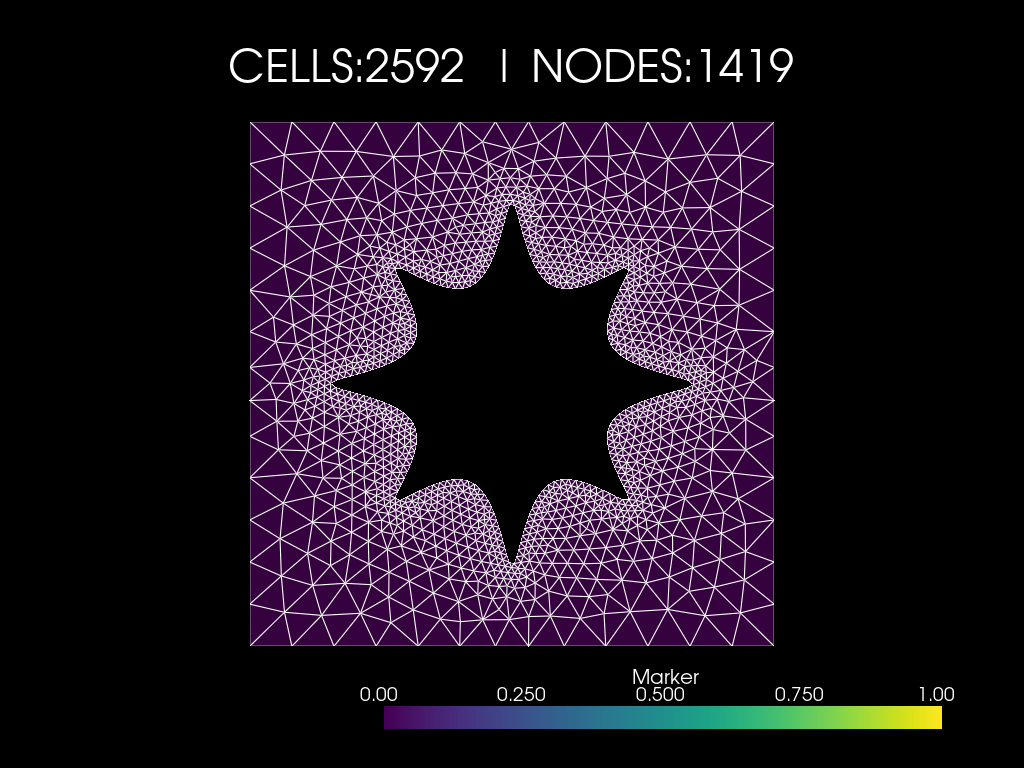

In [36]:
plt = fenonics.PlotSpline(gmsh, r, Nquads, a_len, xpt, ypt)
plt.show()
fenonics.plotmesh(mesh,ct)

## Part 3: Solve on the default $\Gamma$-$\rm X$-$\rm M$-$\Gamma$ boundary

The default function is `solve_bands`, and this solves around the IBZ for 4-quad rotational symmetry in the unit cell. If this symmetry is broken, you may need to pass over more high-symmetry points, in which case see the next cell to set up a custom IBZ path with `solve_bands_customHS`

Now we solve the entire band structure using the finite-element method. The following code solves the eigenproblem along  the $\Gamma$-X-M-$\Gamma$ boundary of the IBZ
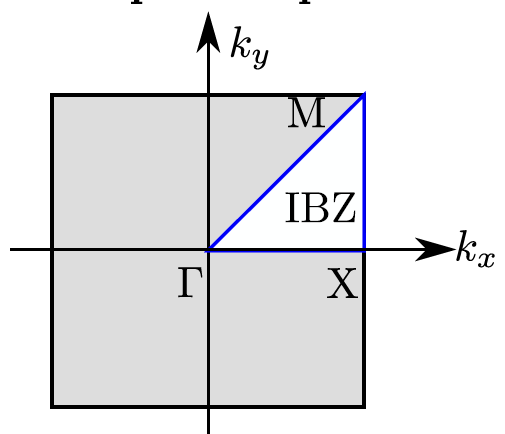

This could be changedby modifying the tuble of high-symmetry points to consider

In [18]:
n_wavevector   = 60 # Number of wavevectors to use over the IBZ loop
n_solutions    = 20 # Number of eigensolutions to return at each wavevector
fspace   = 'CG'     # Function space to use on th mesh

# Function to sovle for the disperision on the default IBZ
evals_disp, evec_all, mpc, KX, KY = fenonics.solve_bands(n_wavevector  = n_wavevector, 
                        n_solutions = n_solutions, a_len = a_len,
                         c = c,  rho = rho,  fspace = fspace,  
                         mesh = mesh, ct = ct)

MPC DEFINED (tag a)
MPC DEFINED (tag a)
MPC DEFINED (tag c)
Computing Band Structure... 
Computing Γ to X
Computing X to M
Computing M to Γ
Time to compute dispersion 2.275
Band computation complete
-----------------
N_dof....2592
N_vectors....20
N_wavenumbers....60
T total....2.275


# Post-Processing and Visualization

We can collect the summary of the band structure with the `getbands()` command.

To visualize, call the `plotbands()` function from the `PostProcess` module to visual the dispersion curves and band gaps.

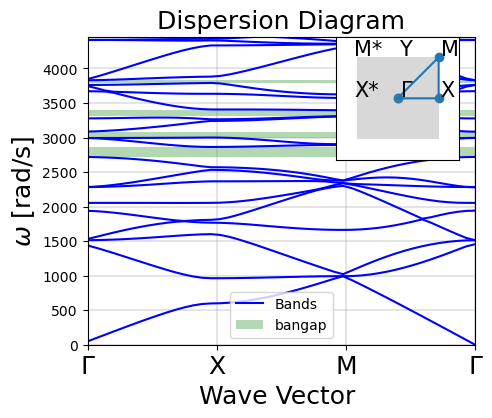

In [4]:
bgnrm, gapwidths, gaps, lowbounds, highbounds = fenonics.getbands(np.array(evals_disp))
plt = fenonics.plotbands(bands = np.array(evals_disp), inset = True, 
                KX = KX, KY = KY, a_len= a_len)
plt.show()

# 4. Compute the Dispersion Diagram on custom High-Symmetry points

Here we show how to define your own IBZ path using the `solve_bands_customHS` function.
We solve on the $\Gamma$-$X$-$M$-$Y$-$\Gamma$ boudnary

In [19]:
# Define the high symmetry points of the lattice. We define Gamma (G), X, M, Y, X' (X*), and M' (M*) 
G  = np.array([0,0])                    
X  = np.array([np.pi/a_len, 0])              
M  = np.array([np.pi/a_len, np.pi/a_len])    
Y  = np.array([0, np.pi/a_len] )   
Mp = np.array([-np.pi/a_len, np.pi/a_len])    
Xp = np.array([-np.pi/a_len, 0] )   

# Create a list of high-symmety coordinates to solve over
HSpts = [G, X, M, 
         G, Y, M,
         G, Xp, Mp,
         G, Y, Mp,
         G]

# Define the number of solutions per wavevec and number of wavevecs to solve for
n_solutions  = 30
n_wavevector = len(HSpts)*10

# Solve teh eiegensolution. Collect eigenvalues, eigenvectors, constrains, and wavevectors
evals_disp, evec_all, mpc, KX, KY = fenonics.solve_bands(HSpts  = HSpts, n_wavevector  = n_wavevector,  
                    n_solutions = n_solutions, a_len = a_len,
                        c = c,  rho = rho,  fspace = 'CG',  
                        mesh = mesh, ct = ct)

MPC DEFINED (tag a)
MPC DEFINED (tag a)
MPC DEFINED (tag c)
Computing Band Structure... 
Computing 0.0 to 1.0
Computing 1.0 to 2.0
Computing 2.0 to 3.0
Computing 3.0 to 4.0
Computing 4.0 to 5.0
Computing 5.0 to 6.0
Computing 6.0 to 7.0
Computing 7.0 to 8.0
Computing 8.0 to 9.0
Computing 9.0 to 10.0
Computing 10.0 to 11.0
Computing 11.0 to 12.0
Time to compute dispersion 8.852
Band computation complete
-----------------
N_dof....2592
N_vectors....30
N_wavenumbers....130
T total....8.852


## 5. Plotting the disperison over a custom IBZ

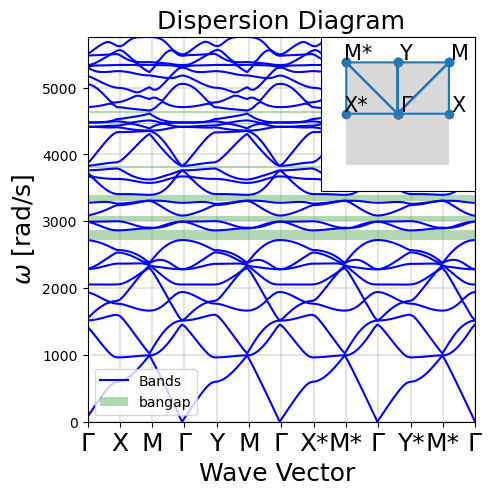

In [20]:
# Define a list of labels for the plotting tool to label the high-symmetry (HS) points
HS_labels = ['$\Gamma$', 'X', 'M', 
             '$\Gamma$', 'Y', 'M',
             '$\Gamma$', 'X*', 'M*',
             '$\Gamma$', 'Y*', 'M*',
             '$\Gamma$']

# Plotting the dispersion output using the user-defined HS point labels
plt = fenonics.plotbands(np.array(evals_disp), figsize = (5,5), HSpts = HSpts, HS_labels = HS_labels, 
                a_len = a_len, KX = KX, KY = KY, inset = True)
plt.show()

## 6. Plotting the Bloch-eigenmodes


No module named 'trame'

Falling back to a static output.
  warnings.warn(



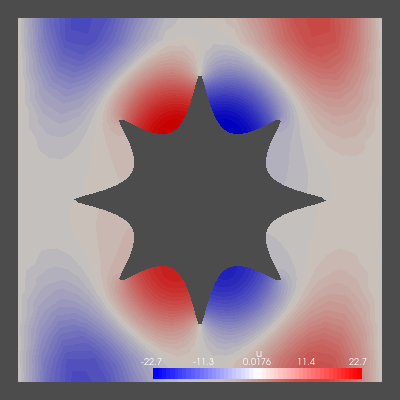

In [21]:
# Initialize the pyvista plotter
plotter = pyvista.Plotter(shape=(1,1) , window_size=(400,400))

# Set the eigenvalue and  wavenumber to plot over
eval_number = 10
wavevec_number = 30
fspace = 'CG'
V = dolfinx.fem.FunctionSpace(mesh,(fspace,1))
plotter = fenonics.plotvecs(plotter = plotter , V = V, mpc = mpc, 
                            evecs = evec_all, eval_number = eval_number,
                            wavevec_number = wavevec_number,cmap = 'bwr')
plotter.show()